# The effectiveness of SHAP for retrieving biologically important genera

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import shap
from sklearn.model_selection import GridSearchCV, RepeatedKFold, cross_validate, KFold, cross_val_score
from sklearn.metrics import make_scorer, explained_variance_score, r2_score, mean_absolute_error
from xgboost import XGBRegressor

cwd = Path.cwd()
print(cwd)
datasets = cwd / '../results/tax_classification_out/abundance_matrices'
results = cwd / '../results/ML_out/regression_out'

/mnt/c/git_repos/pneumonia/ML_scripts


/home/cednotsed/miniconda3/envs/mashin/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Preprocessing

### Load data

In [6]:
### Load data
raw_df = pd.read_csv(datasets / f'RA.G.zeroed.decontam.2.csv')
meta = pd.read_csv(cwd / "../data/metadata/parsed_patient_metadata.filt.csv")

merged_df = raw_df.merge(meta, on='run_id', how='left')
merged_filt = merged_df.loc[merged_df['hap_vap_cap'].isin(['HAP', 'VAP']), :]

# Response
y = merged_filt.loc[:, 'vent_length_hours'].copy()
y = np.log10(y)

# Features
X = merged_filt.loc[:, ~merged_filt.keys().isin(meta.keys())].copy()
X['log_microbial_reads'] = np.log10(merged_filt.microbial_reads)

# Rename features
X.columns = X.columns.str.replace('[^A-Za-z0-9]+', '_')
print(X.shape)
print(y.shape)

TypeError: loop of ufunc does not support argument 0 of type str which has no callable log10 method

### Hyperparameter tuning

In [3]:
## Model training and evaluation
def optimise_evaluate(X, y):
    np.random.seed(66)

    # Hyperparemeter Optimisation using grid search (F1)
    regressor = XGBRegressor()
    n_estimators = range(100, 1000, 200)
    max_depth = range(1, 10, 1)
    colsample_bytree = np.linspace(0.1, 1, 10)

    param_grid = dict(max_depth=max_depth,
                      n_estimators=n_estimators,
                      colsample_bytree=colsample_bytree,
                      n_jobs = [1])

    inner_cv = KFold(n_splits=10, shuffle=True)
    outer_cv = KFold(n_splits=10, shuffle=True)

    # Inner CV
    model = GridSearchCV(regressor,
                         param_grid,
                         scoring='neg_mean_squared_error',
                         n_jobs=6,
                         cv=inner_cv,
                         verbose=1)

    model.fit(X, y)
    best_params = model.best_params_
    print(best_params)
    # Custom metrics
    expl_var = make_scorer(explained_variance_score)
    rsquared = make_scorer(r2_score)
    mae = make_scorer(mean_absolute_error)

    scoring = {'r2': rsquared,
               'mae': mae}

    # Outer CV
    outer_results = cross_validate(model, X=X, y=y, cv=outer_cv, scoring=scoring, n_jobs=4)
    outer_results = pd.DataFrame(outer_results)

    return outer_results, best_params

## Run optimisation

In [4]:
# Tune hyperparameters
raw_results, raw_params = optimise_evaluate(X, y)

# Results
res = pd.DataFrame(raw_results).mean()[['test_r2', 'test_mae']]

Fitting 10 folds for each of 450 candidates, totalling 4500 fits
{'colsample_bytree': 0.1, 'max_depth': 1, 'n_estimators': 100, 'n_jobs': 1}
Fitting 10 folds for each of 450 candidates, totalling 4500 fits
Fitting 10 folds for each of 450 candidates, totalling 4500 fits
Fitting 10 folds for each of 450 candidates, totalling 4500 fits
Fitting 10 folds for each of 450 candidates, totalling 4500 fits
Fitting 10 folds for each of 450 candidates, totalling 4500 fits
Fitting 10 folds for each of 450 candidates, totalling 4500 fits
Fitting 10 folds for each of 450 candidates, totalling 4500 fits
Fitting 10 folds for each of 450 candidates, totalling 4500 fits
Fitting 10 folds for each of 450 candidates, totalling 4500 fits
Fitting 10 folds for each of 450 candidates, totalling 4500 fits


In [5]:
res

test_r2      -1.346703
test_mae    243.847460
dtype: float64

# Permutation test

In [228]:
np.random.seed(66)
score_perm = []
for i in range(1, 100):
    model = XGBRegressor()
    # define model evaluation method
    cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1)
    # evaluate model
    y_perm = y.sample(len(y), replace=False)
    scores_temp = cross_val_score(model, X, y_perm, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    scores_temp = np.absolute(scores_temp)
    mean_score = scores_temp.mean()
    score_perm.append(mean_score)

In [229]:
sum(scores.mean() > score_perm) / 100

0.0

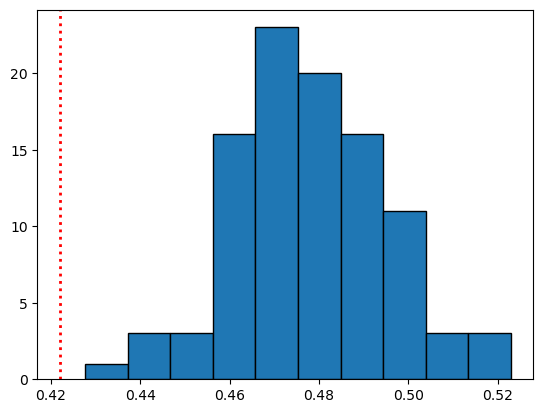

In [230]:
import matplotlib.pyplot as plt

plt.hist(score_perm, bins=10, edgecolor='black')
plt.axvline(scores.mean(), color='red', linestyle='dotted', linewidth=2)

In [231]:
trained = model.fit(X, y)

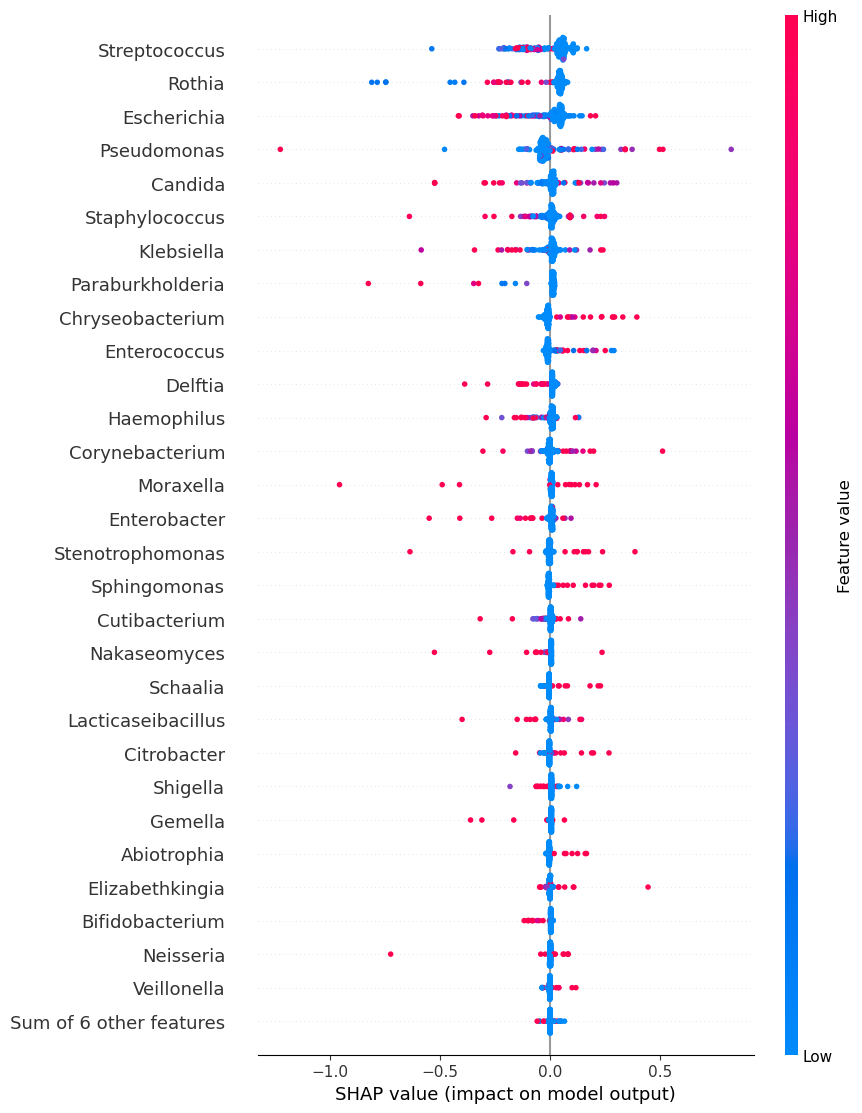

<Figure size 640x480 with 0 Axes>

In [232]:
pred = trained.predict(X, output_margin=True)

explainer = shap.TreeExplainer(trained)
explanation = explainer(X)

shap_values = explanation.values
# make sure the SHAP values add up to marginal predictions
np.abs(shap_values.sum(axis=1) + explanation.base_values - pred).max()

shap.plots.beeswarm(explanation, max_display=30)

plt.savefig(results / 'regression_shap_beeswarm_plot.png', dpi=600, format='png')